In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ase.build import nanotube
from ase.neighborlist import NeighborList
from qtpyt.base.leads import LeadSelfEnergy

from ase.io import read, write
from ase.build import nanotube, bulk
from ase import Atoms
from ase.geometry import get_duplicate_atoms

In [3]:
def get_dd_hopping_matrix(r_vec, dd_sigma, dd_pi, dd_delta):
    """
    Constructs the 5x5 Slater-Koster hopping matrix for d-orbitals between two atoms.

    Parameters
    ----------
    r_vec : np.ndarray
        Displacement vector between two atoms (shape (3,))
    dd_sigma, dd_pi, dd_delta : float
        Slater-Koster hopping parameters (in eV)

    Returns
    -------
    H_dd : np.ndarray
        (5,5) hopping matrix in d-orbital basis:
        [d_xy, d_yz, d_zx, d_x2-y2, d_3z2-r2]
    """
    l, m, n = r_vec / np.linalg.norm(r_vec)

    l2, m2, n2 = l*l, m*m, n*n
    lm, ln, mn = l*m, l*n, m*n

    dd = {
        "σ": dd_sigma,
        "π": dd_pi,
        "δ": dd_delta,
    }

    H = np.zeros((5, 5))

    # Define elements based on SK formulas
    H[0, 0] = 3 * lm**2 * dd["σ"] + (l2 + m2 - 4 * lm**2) * dd["π"] + (n2 + lm**2) * dd["δ"]
    H[1, 1] = 3 * mn**2 * dd["σ"] + (m2 + n2 - 4 * mn**2) * dd["π"] + (l2 + mn**2) * dd["δ"]
    H[2, 2] = 3 * ln**2 * dd["σ"] + (l2 + n2 - 4 * ln**2) * dd["π"] + (m2 + ln**2) * dd["δ"]
    H[3, 3] = (l2 - m2)**2 * dd["σ"] + 4 * l2 * m2 * dd["π"] + n2 * (l2 + m2) * dd["δ"]
    H[4, 4] = (3 * n2 - 1)**2 * dd["σ"] + 3 * (1 - n2) * dd["π"] + 3 * (1 - n2)**2 * dd["δ"]

    # Off-diagonal terms
    H[0, 1] = H[1, 0] = 3 * lm * mn * dd["σ"] + lm * (1 - 4 * mn**2) * dd["π"] + lm * (n2 + mn**2) * dd["δ"]
    H[0, 2] = H[2, 0] = 3 * lm * ln * dd["σ"] + lm * (1 - 4 * ln**2) * dd["π"] + lm * (n2 + ln**2) * dd["δ"]
    H[0, 3] = H[3, 0] = (l2 - m2) * lm * dd["σ"] + lm * (l2 - m2) * dd["π"] - lm * n2 * dd["δ"]
    H[0, 4] = H[4, 0] = n * (l2 + m2 - 2 * lm**2) * dd["σ"] + n * (1 - l2 - m2) * dd["π"] + n * (lm**2) * dd["δ"]

    H[1, 2] = H[2, 1] = 3 * mn * ln * dd["σ"] + mn * (1 - 4 * ln**2) * dd["π"] + mn * (l2 + ln**2) * dd["δ"]
    H[1, 3] = H[3, 1] = (l2 - m2) * mn * dd["σ"] + mn * (m2 - l2) * dd["π"] - mn * n2 * dd["δ"]
    H[1, 4] = H[4, 1] = n * (m2 + n2 - 2 * mn**2) * dd["σ"] + n * (1 - m2 - n2) * dd["π"] + n * (mn**2) * dd["δ"]

    H[2, 3] = H[3, 2] = (l2 - m2) * ln * dd["σ"] + ln * (l2 - m2) * dd["π"] - ln * n2 * dd["δ"]
    H[2, 4] = H[4, 2] = n * (l2 + n2 - 2 * ln**2) * dd["σ"] + n * (1 - l2 - n2) * dd["π"] + n * (ln**2) * dd["δ"]

    H[3, 4] = H[4, 3] = (l2 - m2) * n * dd["σ"] + n * (m2 - l2) * dd["π"] - n * (l2 + m2) * dd["δ"]

    return H


In [8]:
from ase.build import nanotube, bulk
from ase import Atoms
import numpy as np

def build_CNT_Pt_supercell(
    n=6,
    m=0,
    cnt_ucells=1,
    pt_layers=4,
    pt_repeats_y=4,
    bond=1.42,
    pt_a=3.92,
    vacuum_z=10.0
):
    """
    Create a periodic CNT+Pt supercell for Sancho-Rubio.

    Parameters
    ----------
    n, m : int
        CNT chiral indices.
    cnt_ucells : int
        Number of unit cells of CNT in transport direction (x).
    pt_layers : int
        Number of Pt layers (along z).
    pt_repeats_y : int
        Pt repeat count in y-direction.
    bond : float
        CNT bond length.
    pt_a : float
        Pt fcc lattice constant.
    vacuum_z : float
        Vacuum above CNT in z-direction.

    Returns
    -------
    Atoms : Composite ASE structure with periodicity in x.
    """
    # CNT aligned along x, periodic
    cnt = nanotube(n=n, m=m, length=cnt_ucells, bond=bond, verbose=False)
    cnt.rotate("z", "x", rotate_cell=False, center="COP")
    cnt.set_pbc((True, False, False))
    cnt_cell = cnt.get_cell()
    Lx = cnt_cell[0, 0]
    Ly = cnt_cell[1, 1] if cnt_cell[1, 1] > 0 else pt_a * pt_repeats_y

    # Pt (fcc(100)-like slab) repeated in x and y
    pt = bulk("Pt", "fcc", a=pt_a)
    pt = pt.repeat((1, pt_repeats_y, pt_layers))

    # Adjust Pt cell to match CNT along x
    pt.set_cell([Lx, pt.get_cell()[1,1], pt.get_cell()[2,2]])
    pt.set_pbc((True, False, False))

    # Shift CNT to sit above Pt
    z_max_pt = pt.get_positions()[:, 2].max()
    cnt.positions[:, 2] += z_max_pt + 2.2  # vertical offset ~vdW

    # Center CNT in y
    y_range_pt = pt.get_positions()[:, 1].ptp()
    y_range_cnt = cnt.get_positions()[:, 1].ptp()
    y_shift = (y_range_pt - y_range_cnt) / 2
    cnt.positions[:, 1] += y_shift

    # Add vacuum in z
    z_max_cnt = cnt.get_positions()[:, 2].max()
    total_z = z_max_cnt + vacuum_z
    new_cell = np.array([
        [Lx, 0, 0],
        [0, Ly, 0],
        [0, 0, total_z],
    ])

    system = cnt + pt
    system.set_cell(new_cell)
    system.set_pbc((True, False, False))

    return system


In [ ]:
CNT_Pt = build_CNT_Pt_supercell(pt_repeats_y=1, pt_layers=3)
write("CNT_Pt.xyz", CNT_Pt)

In [ ]:
def create_nanotube(n=6, m=0, length=2, bond=1.42, pbc=True, direction="x"):
    """Create a carbon nanotube (CNT) using ASE.

    Args:
        n (int): Chiral index n.
        m (int): Chiral index m.
        length (int): Number of unit cells.
        bond (float): Carbon-carbon bond length.
        pbc (bool): Whether to apply periodic boundary conditions.
        direction (str): Direction of periodicity ('x', 'y', or 'z').

    Returns:
        ase.Atoms: ASE Atoms object representing the CNT.
    """
    atoms = nanotube(n=n, m=m, length=length, bond=bond, verbose=False)
    atoms.rotate("z", "x", rotate_cell=True, center="COP")
    if pbc:
        if direction == "x":
            atoms.set_pbc((1, 0, 0))
        elif direction == "y":
            atoms.set_pbc((0, 1, 0))
        elif direction == "z":
            atoms.set_pbc((0, 0, 1))
        else:
            raise ValueError("Invalid direction. Use 'x', 'y', or 'z'.")
    return atoms

def create_Pt_substrate(size=5, bond=2.77, pbc=True, direction="x"):
    """ Create a platinum (Pt) substrate using ASE."""
    atoms = bulk("Pt", "fcc", a=bond, cubic=True)
    atoms = atoms.repeat((size, size, 1))
    if pbc:
        if direction == "x":
            atoms.set_pbc((1, 0, 0))
        elif direction == "y":
            atoms.set_pbc((0, 1, 0))
        elif direction == "z":
            atoms.set_pbc((0, 0, 1))
        else:
            raise ValueError("Invalid direction. Use 'x', 'y', or 'z'.")
    return atoms

def build_real_space_CNT_hamiltonian(
    atoms, bond=1.42, beta=0.0, t0=-2.7, neighbor_cutoff=1.43, atol=0.1
):
    """Build the intra-cell (H0) and inter-cell (T) Hamiltonians for a CNT lead.

    Args:
        atoms (ase.Atoms): CNT structure with two unit cells.
        bond (float): Ideal bond length (in angstrom).
        beta (float): Exponential decay parameter for hopping.
        t0 (float): Nearest-neighbor hopping at ideal bond length (in eV).
        neighbor_cutoff (float): Distance threshold to consider neighbors.
        atol (float): Absolute tolerance in bond length matching.

    Returns:
        Tuple[np.ndarray, np.ndarray]: H0 and T matrices (both shape (N, N)).
    """
    N_total = len(atoms)
    N_unit = N_total // 2  # atoms in one unit cell

    positions = atoms.get_positions()
    cell = atoms.get_cell()

    # Neighbor list
    cutoffs = [neighbor_cutoff] * N_total
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    # Initialize Hamiltonians
    H0 = np.zeros((N_unit, N_unit), dtype=float)
    T = np.zeros((N_unit, N_unit), dtype=float)

    for i in range(N_total):
        for j, offset in zip(*nl.get_neighbors(i)):
            if j <= i:
                continue
            ri = positions[i]
            rj = positions[j] + np.dot(offset, cell)
            dist = np.linalg.norm(ri - rj)
            if np.abs(dist - bond) > atol:
                continue  # skip non-neighbors
            hopping = t0 * np.exp(-beta * (dist / bond - 1))

            # Intra-cell bond
            if i < N_unit and j < N_unit:
                H0[i, j] = hopping
                H0[j, i] = hopping

            # Inter-cell bond
            elif i < N_unit and j >= N_unit:
                T[i, j - N_unit] = hopping

    return H0, T

def build_real_space_Pt_hamiltonian():
    """Build the Hamiltonian for a platinum (Pt) lead.

    Returns:
        np.ndarray: Hamiltonian matrix for Pt lead.
    """
    # For simplicity, we use a 2x2 Hamiltonian for Pt
    H_Pt = np.array([[0.0, -1.0],
                     [-1.0, 0.0]])
    return H_Pt

def build_CNT_Pt_lead_hamiltonian():
    """Build the Hamiltonian for a carbon nanotube (CNT) lead with platinum (Pt) contacts.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Hamiltonian matrices for CNT lead and Pt contacts.
    """
    H_CNT = build_real_space_CNT_hamiltonian()
    H_Pt = build_real_space_Pt_hamiltonian()
    return H_CNT, H_Pt

def project_self_energy_onto_CNT_lead(H_CNT, H_Pt, energy):
    """Project the self-energy onto the CNT lead.

    Args:
        H_CNT (np.ndarray): Hamiltonian matrix for CNT lead.
        H_Pt (np.ndarray): Hamiltonian matrix for Pt contacts.
        energy (float): Energy at which to compute the self-energy.

    Returns:
        np.ndarray: Projected self-energy matrix.
    """
    # For simplicity, we assume a simple projection
    # In practice, this would involve more complex calculations
    return H_CNT + H_Pt * energy

In [ ]:
# Parameters
n, m = 6, 0
ncells = 2
bond = 1.42
onsite = 0.0  # eV
first_neighbor_hopping = -2.7  # eV
beta = 0  # 3.37
neighbor_cutoff = 1.43  # Å for nearest neighbors
eta = 1e-8  # eV

leads = create_nanotube(n=n, m=m, length=ncells, bond=bond, pbc=True, direction="x")
H0_leads, V_leads = build_real_space_CNT_hamiltonian(
    leads,
    beta=beta,
    t0=first_neighbor_hopping,
    neighbor_cutoff=neighbor_cutoff,
    atol=0.1,
)
S0_leads = np.eye(H0_leads.shape[0])  # Overlap within unit cell
S1_leads = np.zeros_like(H0_leads)  # Overlap between cells

# Initialize self-energy list for left and right leads
self_energy = [None, None]

# Create LeadSelfEnergy objects for left and right leads
# Uses Sancho Rubio method to compute the surface Green's function
self_energy[0] = LeadSelfEnergy(
    (H0_leads, S0_leads),
    (V_leads, S1_leads),
    eta=eta,
)
self_energy[1] = LeadSelfEnergy(
    (H0_leads, S0_leads),
    (V_leads, S1_leads),
    id="right",
    eta=eta,
)


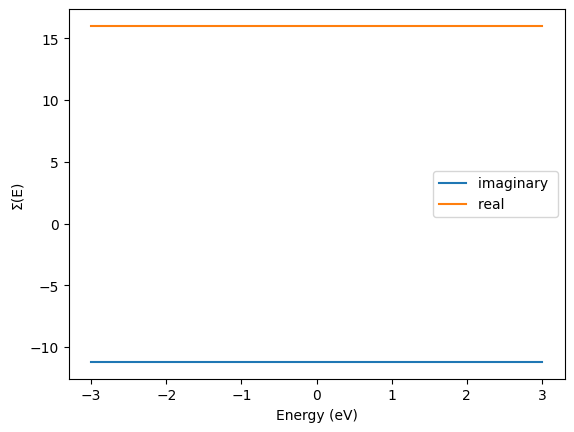

In [12]:
energies = np.linspace(-3, 3, 100)
selfenergy = np.array([self_energy[0].retarded(e) for e in energies])
se_trace = np.trace(selfenergy,axis1=1, axis2=2)

plt.plot(energies, se_trace.imag, label='imaginary ')
plt.plot(energies, se_trace.real, label='real ')
plt.xlabel('Energy (eV)')
plt.ylabel('Σ(E)')
plt.legend()
plt.show()
